# Feature Selection for SPY Volatility Forecasting with Random Forests and a Trading Strategy Application

## Abstract

## 1. Introduction

- .1 Data Overview
- .2 Rolling Window

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import sqrt
from Functions.trading_strategy import *

# Import the main dataset
har_data = pd.read_csv('Data/HAR_data.csv').drop('Unnamed: 0', axis=1)
data = pd.read_csv('Data/data.csv', index_col=0)
# Import fed funds rate data -- used as the risk free rate ('r') in the Black-Scholes equation 
r = pd.read_csv('Data/EFFR.csv', index_col=0)

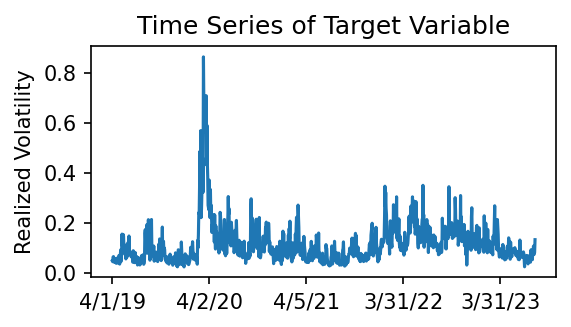

In [76]:
fig, ax = plt.subplots(figsize=(4,2), dpi=150)
ax.plot(data['date'], data['RV_t (Realized Variance)']**.5*(252)**.5)
ax.set_xticks(data['date'][::250])
ax.set_ylabel('Realized Volatility')
ax.set_title('Time Series of Target Variable')
plt.show()

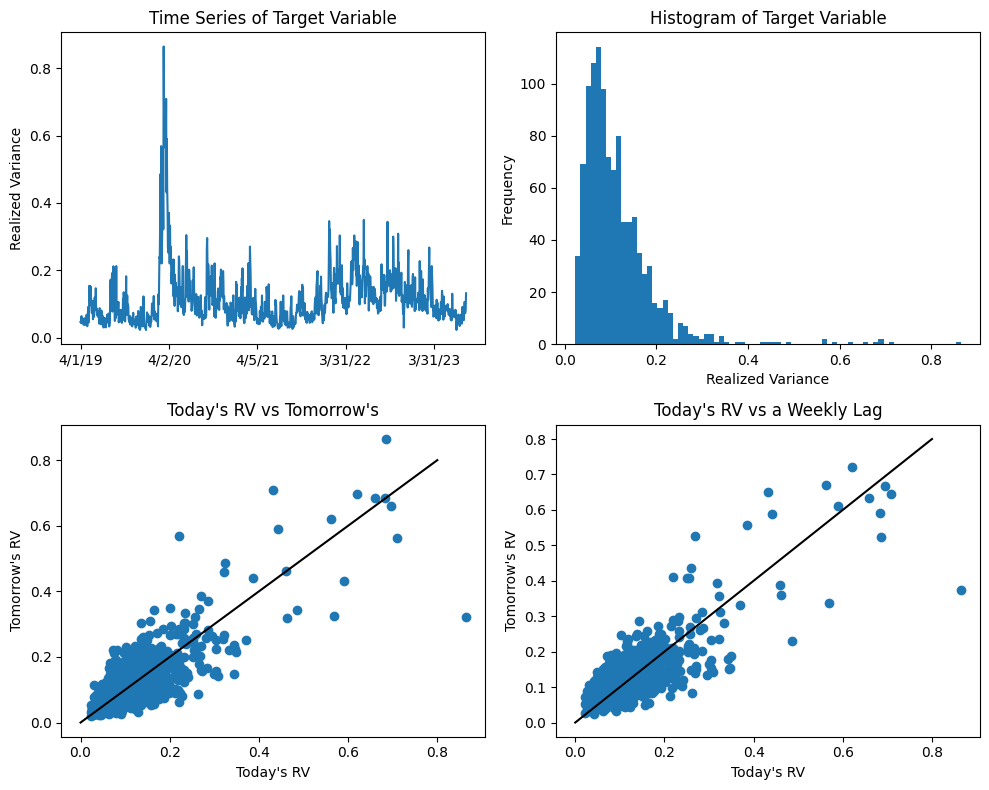

In [31]:
fig, ax = plt.subplots(2,2, figsize=(10,8))
ax[0,0].plot(data['date'], data['RV_t (Realized Variance)']**.5*(252)**.5)
ax[0,0].set_xticks(data['date'][::250])
ax[0,0].set_ylabel('Realized Volatility')
ax[0,0].set_title('Time Series of Target Variable')

ax[0,1].hist(data['RV_t (Realized Variance)']**.5*(252)**.5, bins=75)
ax[0,1].set_xlabel('Realized Volatility')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Histogram of Target Variable')

ax[1,0].scatter(data['RV_t (Realized Volatility)']**.5*(252)**.5, data['RV_(t-1)']**.5*(252)**.5)
ax[1,0].plot([0,.8],[0,.8], color = 'k')
ax[1,0].set_xlabel("Today's RV")
ax[1,0].set_ylabel("Tomorrow's RV")
ax[1,0].set_title("Today's RV vs Tomorrow's")

ax[1,1].scatter(data['RV_t (Realized Volatility)']**.5*(252)**.5, data['RV_t Weekly']**.5*(252)**.5)
ax[1,1].plot([0,.8],[0,.8], color = 'k')
ax[1,1].set_xlabel("Today's RV")
ax[1,1].set_ylabel("Tomorrow's RV")
ax[1,1].set_title("Today's RV vs a Weekly Lag")
fig.tight_layout()
plt.show()

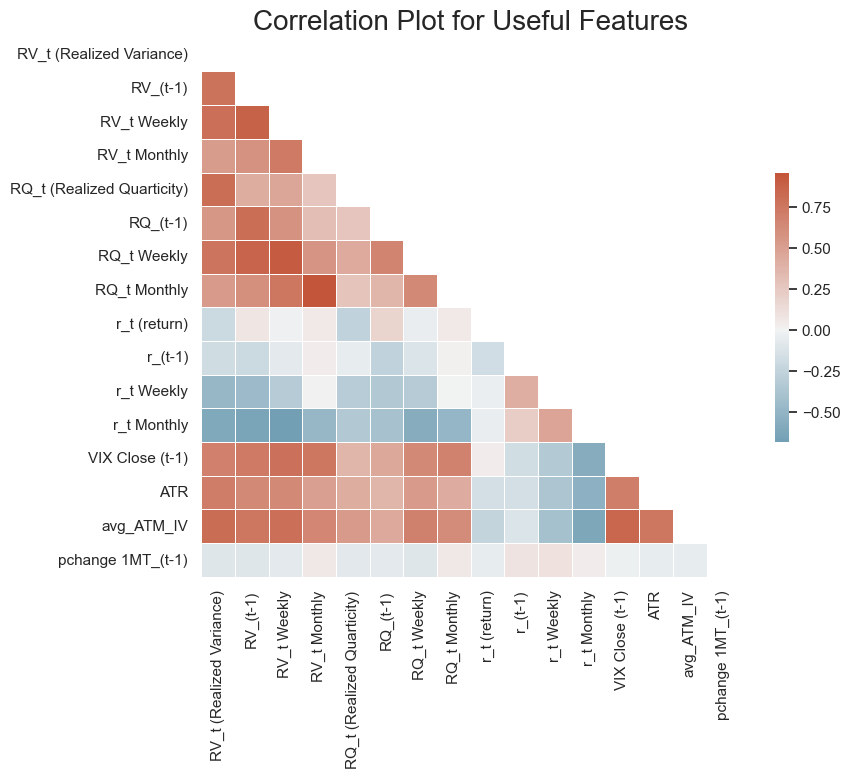

In [57]:
sns.set_theme(style="white")
corr = data.drop(['date','AssetPrice', 'halfDay', 'NumOfDaysSinceLastTradingDay', 'is_friday', 'RV_(t-10)', 'RV_(t-15)','-5c','-5p', '5c', '5p', 'VIX Weekly', 'VIX Monthly'],axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(9, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Plot for Useful Features', fontsize=20)
plt.show()

## 2. The HAR Model

- Introduce Rolling Window Idea

In [44]:
X_har = har_data[['RV_(t-1)','RV_t Weekly', 'RV_t Monthly']]
Y_har = har_data['RV_t (Realized Variance)']

HAR = RollingWindowHAR(X_har,Y_har,har_data['date'],w=300)
print(f"MSE of Basline HAR Model: {round(HAR['mse'],10)}")

MSE of Basline HAR Model: 1.86e-08


## 3. Baseline Random Forest Model

- explain choice of HP

In [80]:
X = data[['RV_(t-1)','RV_t Weekly', 'RV_t Monthly']]
Y = data['RV_t (Realized Variance)']

RF_3f_mse = RollingWindowRF(X,Y,data['date'],method = 'mse', n_trees=40,w=150)
RF_3f_mae = RollingWindowRF(X,Y,data['date'],method = 'mae', n_trees=40,w=150)

In [6]:
print(f"RV Features Only, MSE optimized R^2 relatve to HAR: {round(1 - RF_3f_mse['mse']/(1.86e-8),3)}")
print(f"RV Features Only, MAE optimized R^2 relatve to HAR: {round(1 - RF_3f_mae['mse']/(1.86e-8),3)}")

RV Features Only, MSE optimized R^2 relatve to HAR: 0.124
RV Features Only, MAE optimized R^2 relatve to HAR: 0.131


## 4. Feature Selection for the Random Forest Model

In [70]:
X = data[['RV_(t-1)','RV_t Weekly', 'RV_t Monthly']]
Y = data['RV_t (Realized Variance)']

#### Add Realied Quarticity Features

In [71]:
X = pd.concat([X,
               data[['RQ_(t-1)','RQ_t Weekly', 'RQ_t Monthly']]
          ], axis=1)

RF_6f_mse = RollingWindowRF(X,Y,data['date'],method = 'mse', n_trees=40,w=150)
RF_6f_mae = RollingWindowRF(X,Y,data['date'],method = 'mae', n_trees=40,w=150)

In [9]:
print(f"RV and RQ Features Only, MSE optimized R^2 relatve to HAR: {round(1 - RF_6f_mse['mse']/(1.86e-8),3)}")
print(f"RV and RQ Features Only, MAE optimized R^2 relatve to HAR: {round(1 - RF_6f_mae['mse']/(1.86e-8),3)}")

RV and RQ Features Only, MSE optimized R^2 relatve to HAR: 0.125
RV and RQ Features Only, MAE optimized R^2 relatve to HAR: 0.127


#### Add Return Features, Drop Quarticity Features

In [81]:
X.drop(['RQ_(t-1)','RQ_t Weekly', 'RQ_t Monthly'], axis=1, inplace=True)
X = pd.concat([X,
               data[['r_(t-1)', 'r_t Weekly', 'r_t Monthly']]]
               , axis=1)

RF_9f_mse = RollingWindowRF(X,Y,data['date'],w=150,n_trees=40, method='mse')
RF_9f_mae = RollingWindowRF(X,Y,data['date'],w=150,n_trees=40, method='mae')

In [73]:
print(f"RV, Return Features, MSE optimized R^2 relatve to HAR: {round(1 - RF_9f_mse['mse']/(1.86e-8),3)}")
print(f"RV, Return Features, MAE optimized R^2 relatve to HAR: {round(1 - RF_9f_mae['mse']/(1.86e-8),3)}")

RV, Return Features, MSE optimized R^2 relatve to HAR: 0.265
RV, Return Features, MAE optimized R^2 relatve to HAR: 0.3


#### Add 30D VIX, 1M Treausry Yield, Friday Indicator

In [82]:
X = pd.concat([X, 
          data[['VIX Close (t-1)', 'is_friday', 'pchange 1MT_(t-1)']]]
          ,axis=1)

RF_with_some_exog_features_mae = RollingWindowRF(X,Y,data['date'],w=150,n_trees=40, method='mae')
RF_with_some_exog_features_mse = RollingWindowRF(X,Y,data['date'],w=150,n_trees=40, method='mse')

In [75]:
print(f"RV/RQ/Return + Some Exogenous Features, MSE optimized R^2 relatve to HAR: {round(1 - RF_with_some_exog_features_mse['mse']/(1.86e-8),3)}")
print(f"RV/RQ/Return + Some Exogenous Features, MAE optimized R^2 relatve to HAR: {round(1 - RF_with_some_exog_features_mae['mse']/(1.86e-8),3)}")

RV/RQ/Return + Some Exogenous Features, MSE optimized R^2 relatve to HAR: 0.245
RV/RQ/Return + Some Exogenous Features, MAE optimized R^2 relatve to HAR: 0.256


#### Add Short Term ATM IV and Average True Range Technical Indicator Features

In [83]:
X = pd.concat([X, 
          data[['avg_ATM_IV', 'ATR']]]
          ,axis=1)

# RF_best_mae = RollingWindowRF(X,Y,data['date'],w=150,n_trees=40, method='mae')
# RF_best_mse = RollingWindowRF(X,Y,data['date'],w=150,n_trees=40, method='mse', SHAP=True)

In [16]:
print(f"RV/RQ/Return + Some Exogenous Features + IV Feature, MSE optimized R^2 relatve to HAR: {round(1 - RF_best_mse['mse']/(1.86e-8),3)}")
print(f"RV/RQ/Return + Some Exogenous Features + IV Feature, MAE optimized R^2 relatve to HAR: {round(1 - RF_best_mae['mse']/(1.86e-8),3)}")

RV/RQ/Return + Some Exogenous Features + IV Feature, MSE optimized R^2 relatve to HAR: 0.442
RV/RQ/Return + Some Exogenous Features + IV Feature, MAE optimized R^2 relatve to HAR: 0.415


### 4.2 Comparison vs HAR Results

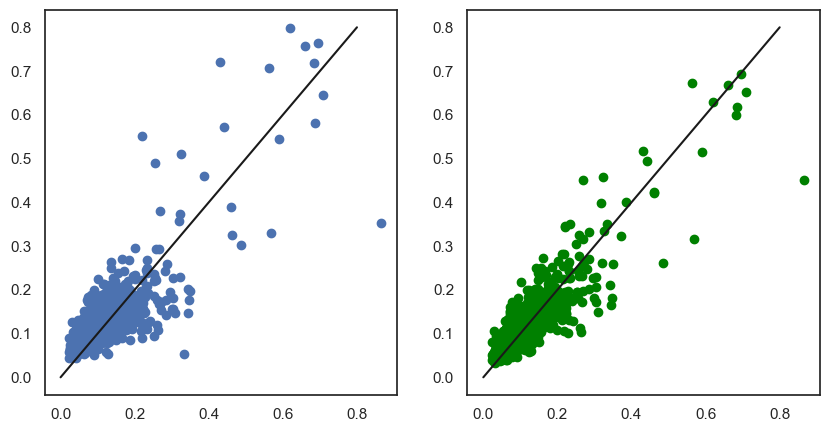

In [18]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].scatter(data['RV_t (Realized Variance)'][150:]**.5*(252)**.5, HAR['predictions'].T**.5*(252)**.5)
ax[0].plot([0,.8],[0,.8], color='k')

ax[1].scatter(data['RV_t (Realized Variance)'][150:]**.5*(252)**.5, RF_best_mse['predictions'].T**.5*(252)**.5, c='green')
ax[1].plot([0,.8],[0,.8], color='k')

plt.show()

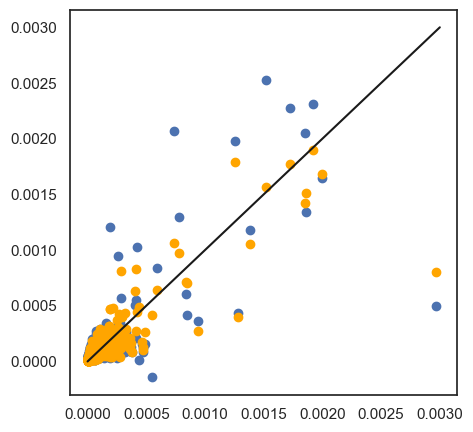

In [53]:
plt.figure(figsize=(5,5))
plt.scatter(data['RV_t (Realized Variance)'][150:], HAR['predictions'].T**.5*(252)**.5)
plt.scatter(data['RV_t (Realized Variance)'][150:], RF_best_mse['predictions'].T**.5*(252)**.5, c='orange')
plt.plot([0,.003],[0,.003], color='k')

plt.show()

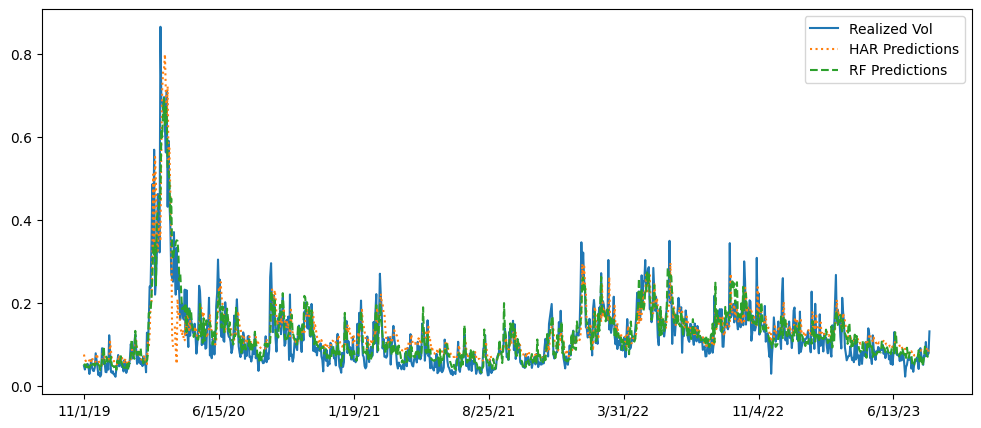

In [34]:
plt.figure(figsize=(12,5))
plt.plot(data['date'][150:], data['RV_t (Realized Variance)'][150:]**.5*(252)**.5, label='Realized Vol')
plt.plot(data['date'][150:], HAR['predictions'].T**.5*(252)**.5, label='HAR Predictions', ls=':')
plt.plot(data['date'][150:], RF_best_mse['predictions'].T**.5*(252)**.5, label='RF Predictions', ls='--')
plt.xticks(data['date'][150::150])
plt.legend()
plt.show()

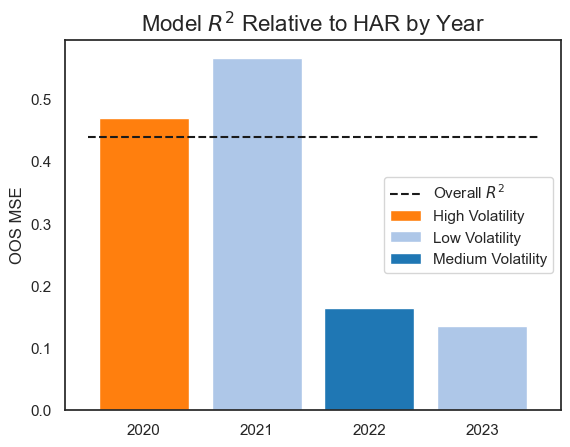

In [37]:
MSE_2020_RF = mean_squared_error(RF_best_mse['predictions'].T.iloc[:290], data['RV_t (Realized Variance)'].iloc[150:440])
MSE_2021_RF = mean_squared_error(RF_best_mse['predictions'].T.iloc[290:540], data['RV_t (Realized Variance)'].iloc[440:690])
MSE_2022_RF = mean_squared_error(RF_best_mse['predictions'].T.iloc[540:789], data['RV_t (Realized Variance)'].iloc[690:939])
MSE_2023_RF = mean_squared_error(RF_best_mse['predictions'].T.iloc[789:], data['RV_t (Realized Variance)'].iloc[939:])

MSE_2020_HAR = mean_squared_error(HAR['predictions'].T.iloc[:290], data['RV_t (Realized Variance)'].iloc[150:440])
MSE_2021_HAR = mean_squared_error(HAR['predictions'].T.iloc[290:540], data['RV_t (Realized Variance)'].iloc[440:690])
MSE_2022_HAR = mean_squared_error(HAR['predictions'].T.iloc[540:789], data['RV_t (Realized Variance)'].iloc[690:939])
MSE_2023_HAR = mean_squared_error(HAR['predictions'].T.iloc[789:], data['RV_t (Realized Variance)'].iloc[939:])

bar_heights = [1-MSE_2020_RF/MSE_2020_HAR, 1-MSE_2021_RF/MSE_2021_HAR, 1-MSE_2022_RF/MSE_2022_HAR, 1-MSE_2023_RF/MSE_2023_HAR]
years = [2020,2021,2022,2023]
colors = ['#ff7f0e', '#aec7e8', '#1f77b4','#aec7e8']
labels = ['High Volatility', 'Low Volatility', 'Medium Volatility']
for i in range(len(years)):
    plt.bar(years[i], bar_heights[i], color=colors[i], label=labels[i] if i < len(labels) else "")
plt.plot([2019.5,2023.5],[.44]*2, ls='--', color='k', label = 'Overall $R^2$')
plt.xticks([2020,2021,2022,2023])
plt.ylabel('OOS MSE')
plt.title('Model $R^2$ Relative to HAR by Year', fontsize=16)
plt.legend()
plt.show()

Note: Overall R^2 doesn't lineup since 2 extra months for 2022, 4 less months for 2023

### 4.3 Feature Importance

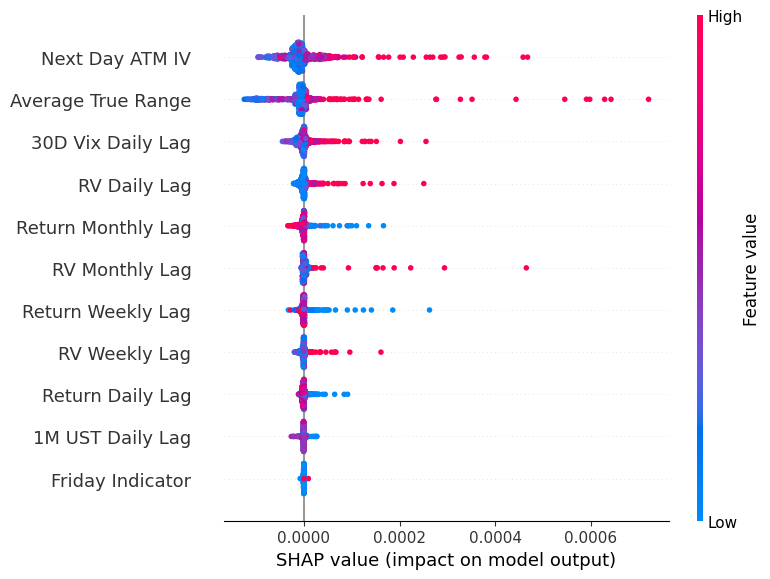

In [109]:
import shap
shap_values = RF_best_mse['feature_importance'].T
shap.summary_plot(shap_values, X[150:].rename({'avg_ATM_IV': 'Next Day ATM IV', 'ATR': 'Average True Range', 'VIX Close (t-1)': '30D Vix Daily Lag', 
                                               'RV_(t-1)': 'RV Daily Lag', 'r_t Monthly': 'Return Monthly Lag', 'RV_t Monthly': 'RV Monthly Lag',
                                               'r_t Weekly': 'Return Weekly Lag', 'RV_t Weekly': 'RV Weekly Lag', 'r_(t-1)': 'Return Daily Lag',
                                               'pchange 1MT_(t-1)': '1M UST Daily Lag', 'is_friday': 'Friday Indicator'}, axis=1))

## 5. Hyperparameter Tuning

## 6. Option Trading Strategy Application

In [2]:
# Import trading days package
import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')
start_date = '2019-01-01'
end_date = '2023-12-31'
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
trading_days = schedule['market_open'].dt.date.tolist()

In [97]:
[strategy_result_RF,strategy_return_time_series_RF] = RunStrategy(RF_predictions, dates, trading_days, r, thresh=1, num_strikes=1,comparison='mean',results_data=strategy_return_data, analysis=True)

In [10]:
# Import data
strategy_return_data = pd.read_csv('Data/option_strategy_return_data.csv',index_col=0)
RF_predictions = pd.read_csv('Data/RF_Best_Model_Predictions.csv', index_col=0)
HAR_predictions = pd.read_csv('Data/HAR_Predictions.csv', index_col=0)
dates = dates = pd.Series(RF_predictions.index)

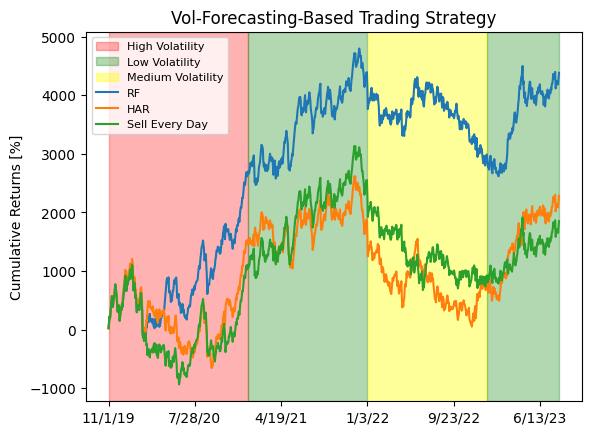

In [99]:
[strategy_result_RF,strategy_return_time_series_RF] = RunStrategy(RF_predictions, dates, trading_days, r, thresh=1, num_strikes=1,comparison='mean',results_data=strategy_return_data, analysis=True)
[strategy_result_HAR,strategy_return_time_series_HAR] = RunStrategy(HAR_predictions, dates, trading_days, r, thresh=1, num_strikes=1,comparison='mean',results_data=strategy_return_data, analysis=True)


high_vol_start, high_vol_end = 0, 290
low_vol_start_1, low_vol_end_1 = 291, 540
med_vol_start, med_vol_end = 541, 789
low_vol_start_2, low_vol_end_2 = 790, len(strategy_return_time_series_RF)

# Start plotting
fig, ax = plt.subplots()

# Shade volatility regions
ax.axvspan(high_vol_start, high_vol_end, color='red', alpha=0.3, label='High Volatility')
ax.axvspan(low_vol_start_1, low_vol_end_1, color='green', alpha=0.3, label='Low Volatility')
ax.axvspan(med_vol_start, med_vol_end, color='yellow', alpha=0.4, label='Medium Volatility')
ax.axvspan(low_vol_start_2, low_vol_end_2, color='green', alpha=0.3)

plt.plot(strategy_return_time_series_RF, label='RF')
plt.plot(strategy_return_time_series_HAR, label='HAR')
plt.plot(strategy_return_data['Return [%]'].cumsum()*-1, label = 'Sell Every Day')
plt.legend(fontsize=8)
plt.xticks(dates[::180])
plt.title('Vol-Forecasting-Based Trading Strategy')
plt.ylabel('Cumulative Returns [%]')
plt.show()

In [108]:
rs = [d['Return'] for d in strategy_result_RF]
neg_rs = [d for d in rs if d<0]
sortino_ratio = np.mean(rs) / np.std(neg_rs) * np.sqrt(252)
sortino_ratio

1.1028693450969245

- sortino ratio
- max drawdown
- CVAR

In [26]:
# Find Beta
import statsmodels.api as sm

# Assuming `strategy_returns` and `market_returns` are your aligned pandas Series or single-column DataFrames:
X = sm.add_constant((1 - np.exp(data['r_t (return)'][150:].reset_index(drop=True)))*100)  # Adds a constant term to the predictor
model = sm.OLS(strategy_return_time_series_RF, X).fit()

# The slope (beta) is the coefficient of the market returns
beta = model.params[1]

print(f"Beta: {beta}")
print(model.summary())  # Gives you the full regression results

Beta: 9.984477601204638
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1009
Date:                Sun, 03 Mar 2024   Prob (F-statistic):              0.751
Time:                        11:45:18   Log-Likelihood:                -8154.6
No. Observations:                 941   AIC:                         1.631e+04
Df Residuals:                     939   BIC:                         1.632e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2760.9909 

## 7. Conclusions